In [10]:
import numpy as np
import jax.numpy as jnp
import jax


from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
from circuitmap import NeuralDemixer

import sys
sys.path.append('../')
import grid_utils as util
import subtract_utils as subtract_utils
%reload_ext subtract_utils
import os
import glob

plt.rcParams['figure.dpi'] = 300


In [11]:
dset_name = "220308_B6_Chrome2fGC8_030822_Cell2_OpsPositive_A"
ms_path = "../figures/full_pipeline/220308_B6_Chrome2fGC8_030822_Cell1/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_grid_subtractr_caviar_results.npz" # fill in here
ss_path = "../figures/full_pipeline/220308_B6_Chrome2fGC8_030822_Cell1/220308_B6_Chrome2fGC8_030822_Cell1_OpsPositive_A_planes_subtractr_caviar_results.npz" # fill in

ms_results = np.load(ms_path, allow_pickle=True)
ss_results = np.load(ss_path, allow_pickle=True)

In [24]:
from pc_subtractr_network import Subtractr
network_path = "../lightning_logs/version_413830/checkpoints/epoch=277-step=2780000.ckpt"
pc_net = Subtractr(args=None).load_from_checkpoint(network_path)

net_subtracted = pc_net.run(ss_results['raw_matrix'], normalize=True)


Running photocurrent removal...complete (elapsed time 54.78s, device=cpu).


In [25]:
net_subtracted_tensor = util.make_psc_tensor(np.squeeze(net_subtracted),
    ss_results['I'], np.squeeze(ss_results['L']))

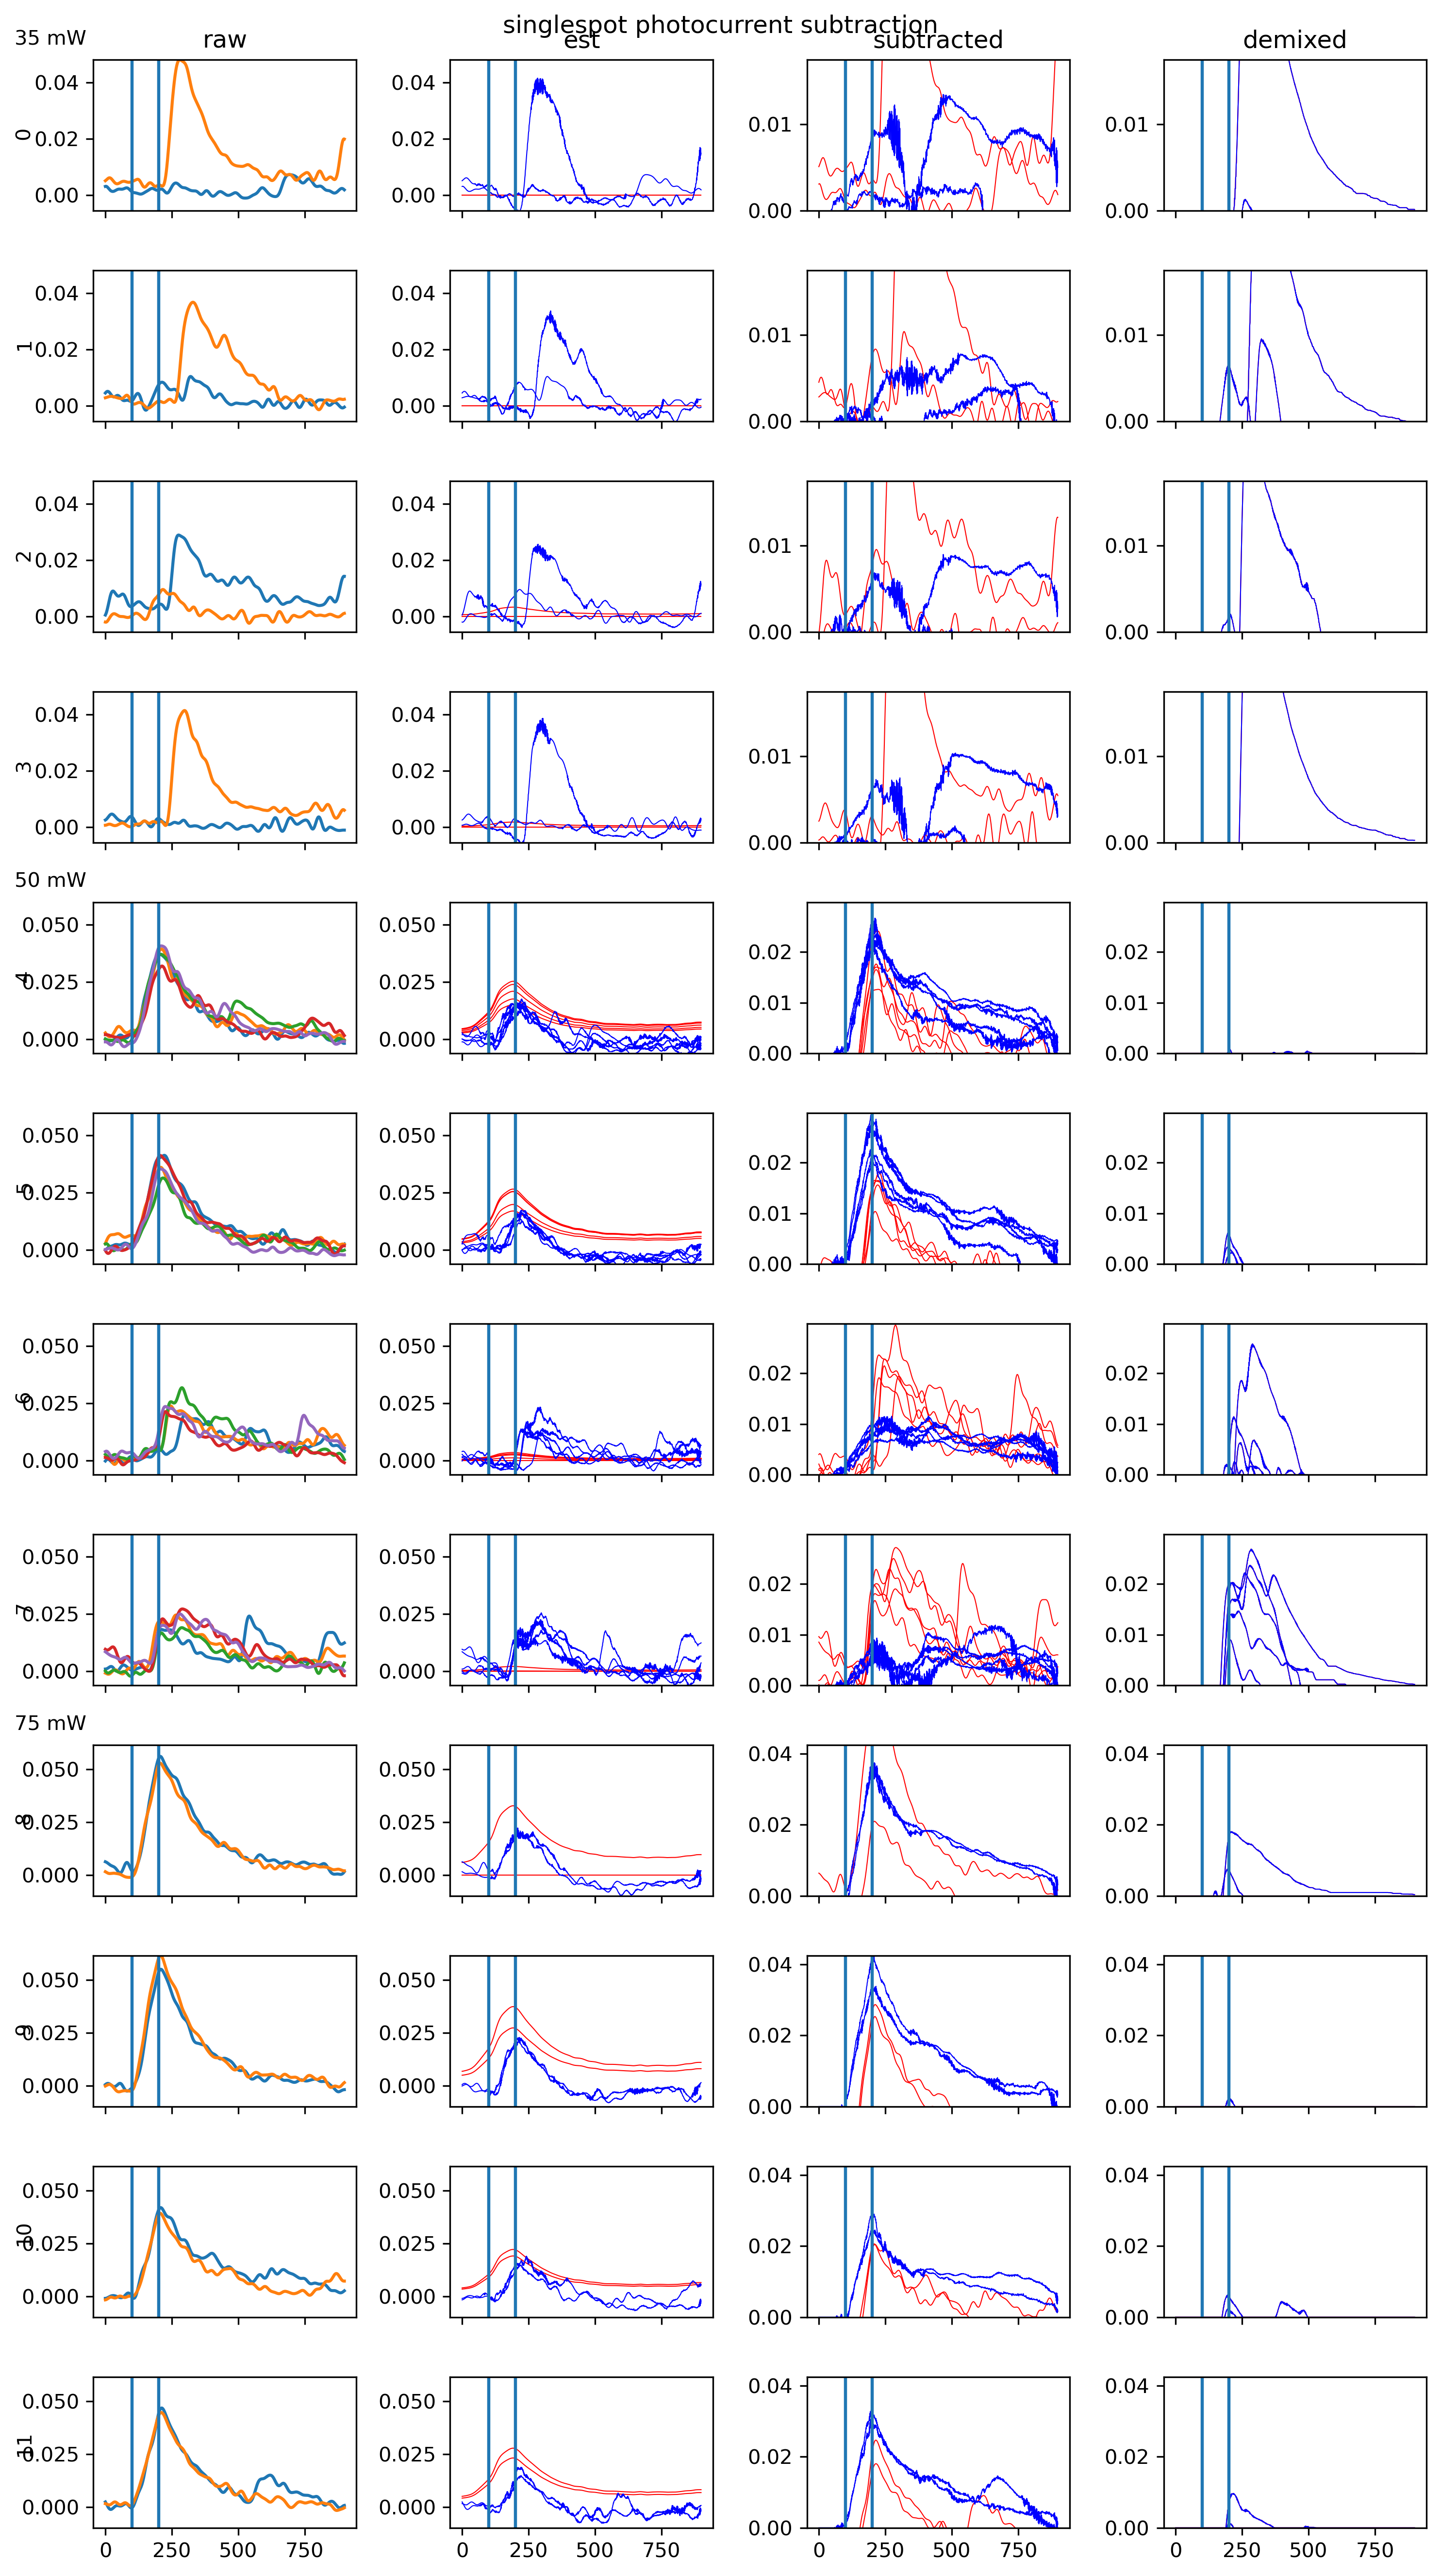

In [26]:

# %matplotlib widget
fig3, axs = subtract_utils.plot_subtraction_comparison(
        ss_results['raw_tensor'],
        [ss_results['est_tensor'], ss_results['raw_tensor'] - net_subtracted_tensor ],
        [ss_results['subtracted_tensor'], net_subtracted_tensor],
        [ss_results['demixed_tensor'], ss_results['demixed_tensor']],
        powers=np.unique(ss_results['I']),
        num_plots_per_power=4,
)
plt.suptitle('singlespot photocurrent subtraction')
plt.tight_layout()
# plt.savefig(dset_name + 'singlespot_photocurrent_subtraction' + '.png', bbox_inches='tight')
plt.show()

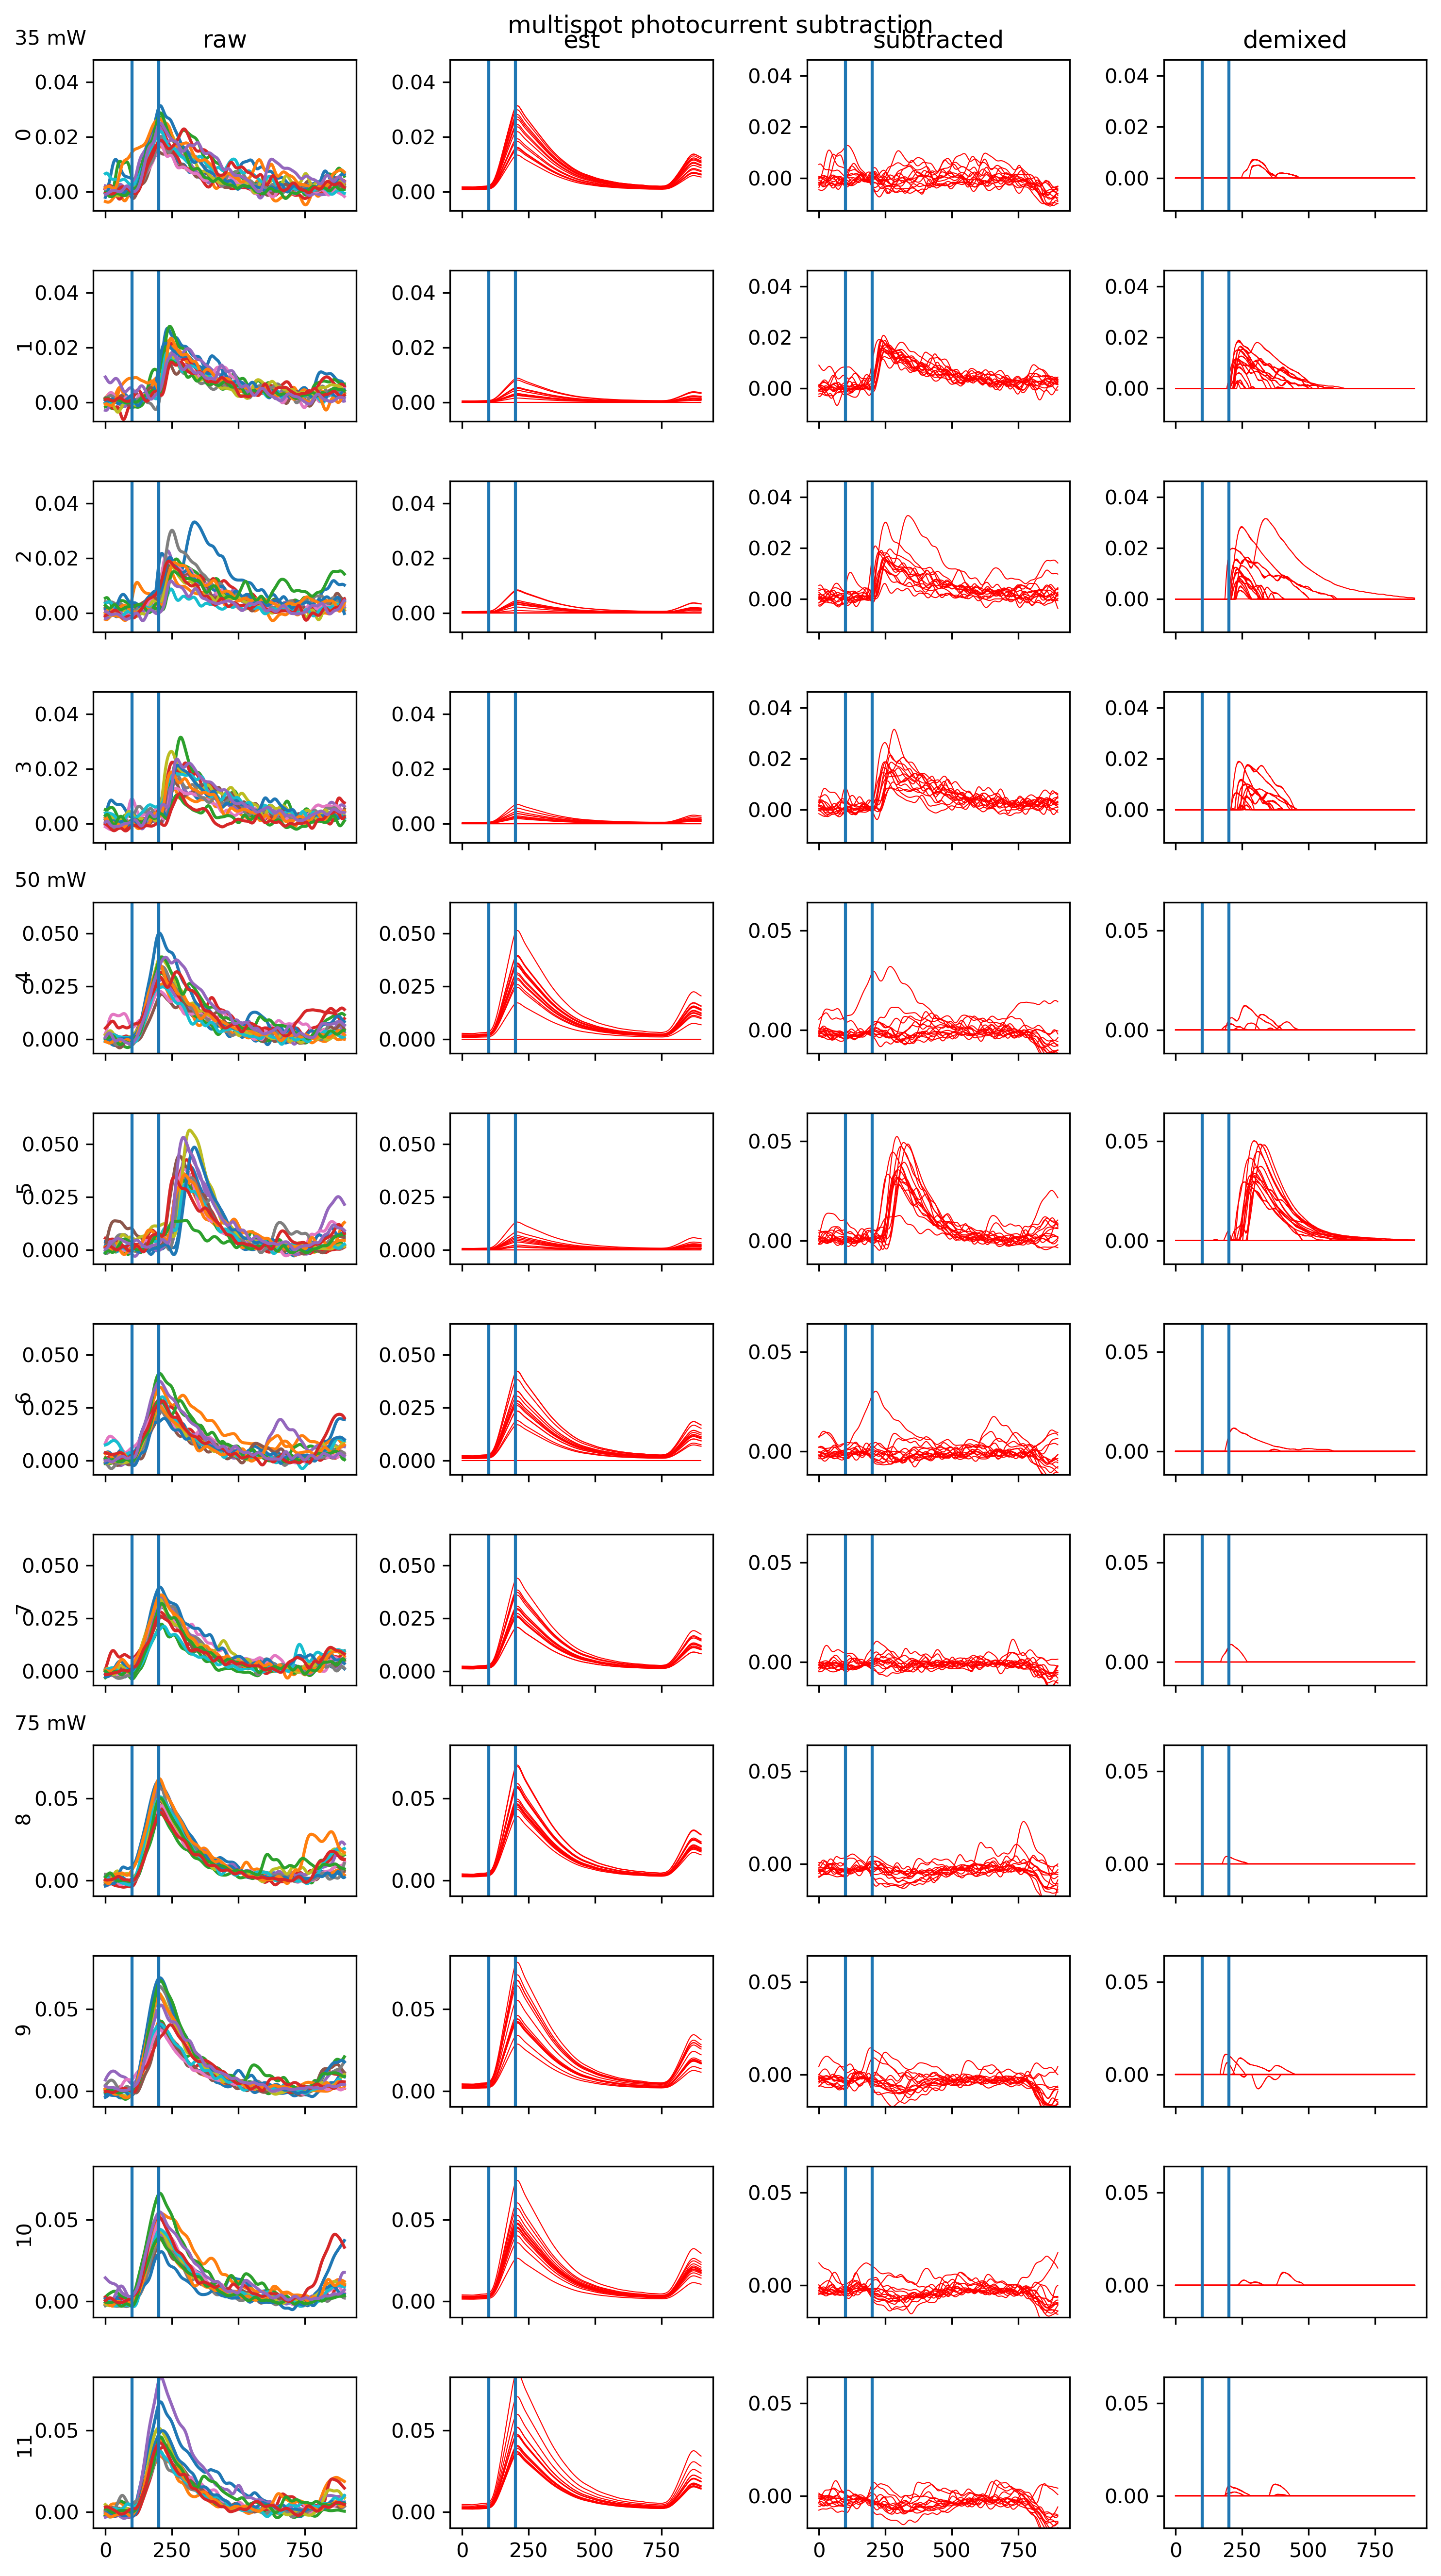

In [72]:

# %matplotlib widget
fig3, axs = subtract_utils.plot_subtraction_comparison(
        ms_results['raw_tensor'],
        [ms_results['est_tensor']],
        [ms_results['subtracted_tensor']],
        [ms_results['demixed_tensor']],
        powers=np.unique(ms_results['I']),
        num_plots_per_power=4,
)
plt.suptitle('multispot photocurrent subtraction')
plt.tight_layout()
plt.savefig(dset_name + 'multispot_photocurrent_subtraction' + '.png', bbox_inches='tight')
plt.show()

In [79]:
ss_state = ss_results['model_state'].item()
ss_weights = ss_state['mu']

ms_state = ms_results['model_state'].item()
ms_weights = ms_state['mu']

ss_map_raw, ss_map_subtracted, ss_map_demixed = [np.nanmean(np.sum(t[...,0:800], axis=-1), axis=-1)
    for t in (ss_results['raw_tensor'], ss_results['subtracted_tensor'], ss_results['demixed_tensor'])]


In [80]:
ss_map_raw.shape

(3, 26, 26, 5)

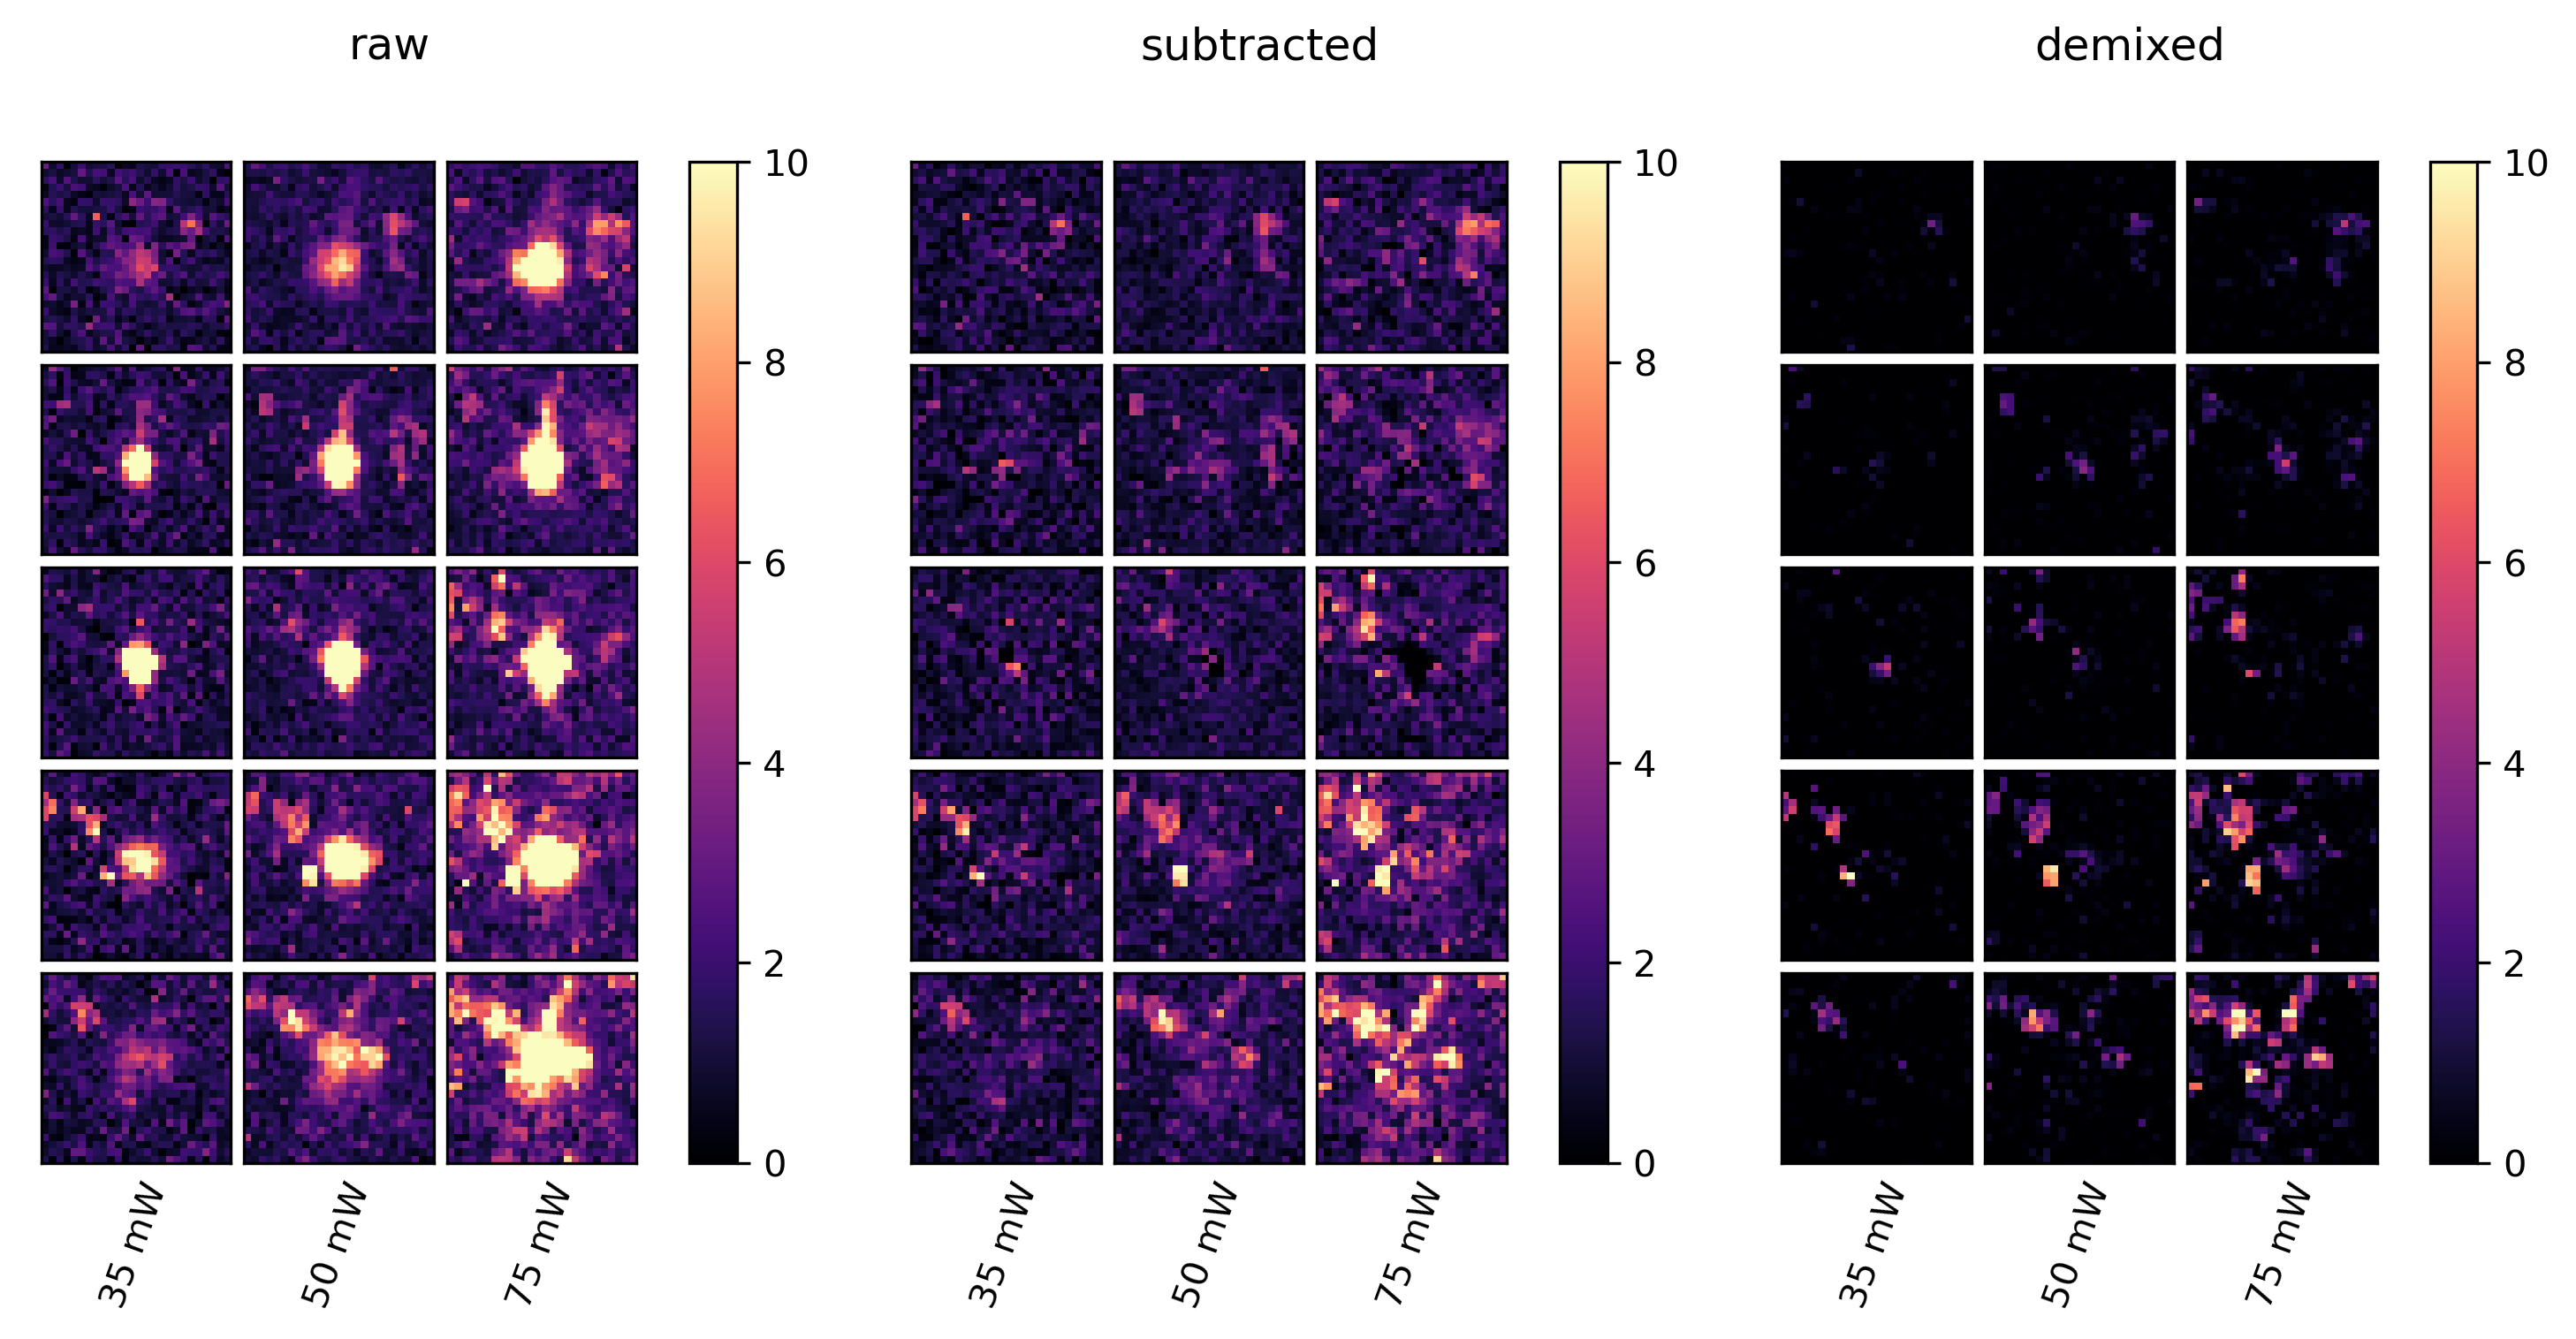

In [81]:
num_planes = ss_map_raw.shape[-1]
num_powers = ss_map_raw.shape[0]
fig2 = plt.figure(figsize=(4 * num_powers, num_planes), dpi=300, facecolor='white')

util.plot_multi_means(fig2,
    [ss_map_raw, ss_map_subtracted, ss_map_demixed],
    np.arange(num_planes),
    cmaps=['magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['raw', 'subtracted', 'demixed'],
    vranges=[(0,10), (0,10), (0,10)],
    powers=np.unique(ss_results['I']),
    )

plt.savefig(dset_name + 'singlespot_maps.png', bbox_inches='tight')
plt.show()

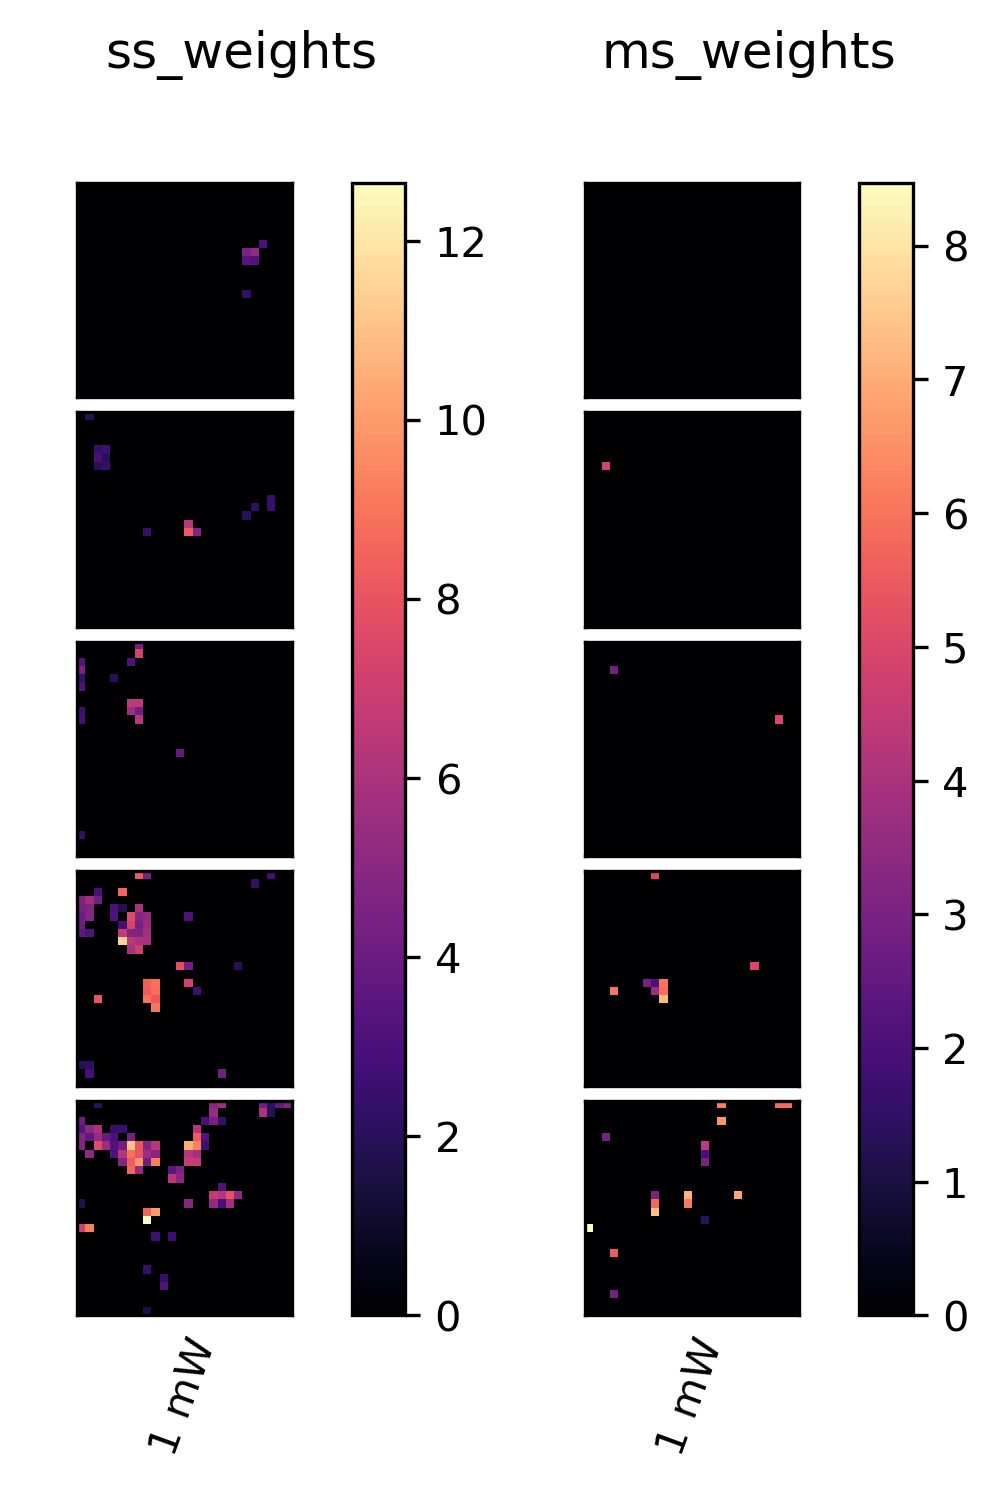

In [82]:
num_planes = 5
fig2 = plt.figure(figsize=(4, num_planes), dpi=300, facecolor='white')

util.plot_multi_means(fig2,
    [ss_weights.reshape(1,26,26,5),
     ms_weights.reshape(1,26,26,5),],
    np.arange(num_planes),
    cmaps=['magma', 'magma', 'magma'],
    # cbar_labels=['EPSQ (nC)'],
    # zlabels=['subtr', 'demix'],
    map_names=['ss_weights', 'ms_weights'],
    # vranges=[(0,10), (0,10), (0,10)],
    powers=(1,),
    )

plt.savefig(dset_name + '_inferred_weights.png', bbox_inches='tight')
plt.show()